In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report ,confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import GridSearchCV
import joblib

import warnings
warnings.filterwarnings("ignore")
#sns.set()

In [2]:
# Load the data
DF = pd.read_csv('../data/raw-data.csv')
DF

category                                      product_title  \
0    Smart Locks and Entry  TP-Link Tapo Smart Door Lock, Deadbolt | Keyle...   
1    Smart Locks and Entry  TP-Link Tapo Smart Door Lock, Deadbolt | Keyle...   
2    Smart Locks and Entry  TP-Link Tapo Smart Door Lock, Deadbolt | Keyle...   
3    Smart Locks and Entry  TP-Link Tapo Smart Door Lock, Deadbolt | Keyle...   
4    Smart Locks and Entry  TP-Link Tapo Smart Door Lock, Deadbolt | Keyle...   
..                     ...                                                ...   
927             Smart WiFi  Reyee Whole Home Mesh WiFi System, AX3200 Smar...   
928             Smart WiFi  Reyee Whole Home Mesh WiFi System, AX3200 Smar...   
929             Smart WiFi  Reyee Whole Home Mesh WiFi System, AX3200 Smar...   
930             Smart WiFi  Reyee Whole Home Mesh WiFi System, AX3200 Smar...   
931             Smart WiFi  Reyee Whole Home Mesh WiFi System, AX3200 Smar...   

    product_price product_rating product_review_count  \
0            114.            4.5                  357   
1            114.            4.5                  357   
2            114.            4.5                  357   
3            114.            4.5                  357   
4            114.            4.5                  357   
..            ...            ...                  ...   
927           69.            4.2                  491   
928           69.            4.2                  491   
929           69.            4.2                  491   
930           69.            4.2                  491   
931           69.            4.2                  491   

                             product_url  review_rating         review_date  \
0    https://us.amazon.com/dp/B0DKQQ6Z7Q            5.0       June 15, 2025   
1    https://us.amazon.com/dp/B0DKQQ6Z7Q            5.0        June 5, 2025   
2    https://us.amazon.com/dp/B0DKQQ6Z7Q            5.0     October 7, 2025   
3    https://us.amazon.com/dp/B0DKQQ6Z7Q            4.0      March 27, 2025   
4    https://us.amazon.com/dp/B0DKQQ6Z7Q            5.0  September 10, 2025   
..                                   ...            ...                 ...   
927  https://us.amazon.com/dp/B0BY2KF88C            5.0       June 27, 2023   
928  https://us.amazon.com/dp/B0BY2KF88C            5.0       July 16, 2025   
929  https://us.amazon.com/dp/B0BY2KF88C            5.0    October 25, 2024   
930  https://us.amazon.com/dp/B0BY2KF88C            1.0       July 30, 2025   
931  https://us.amazon.com/dp/B0BY2KF88C            4.0   September 4, 2025   

                                          review_title  \
0    5.0 out of 5 starsBest Smart Lock Ever ‚Äì A Tot...   
1    5.0 out of 5 starsExcellent smart lock! Highly...   
2    5.0 out of 5 starsFingerprint Recognition is A...   
3    4.0 out of 5 starsGood option, especially if y...   
4            5.0 out of 5 starsExcellent and a bargain   
..                                                 ...   
927      5.0 out of 5 starsWhole Home Mesh WiFi System   
928               5.0 out of 5 starsStrong WIFI signal   
929  5.0 out of 5 starsIt's the Best router I have ...   
930       1.0 out of 5 starsNo tech support at all !!!   
931      4.0 out of 5 starsOver all working as claimed   

                                        review_content  
0    This smart lock is hands-down my best purchase...  
1    LOVE this lock! Super easy installation and pr...  
2    This lock is great. I've had it installed on m...  
3    This was a good choice for me, especially sinc...  
4    I installed a wyze door lock gave up on me aft...  
..                                                 ...  
927  The media could not be loaded.This cutting-edg...  
928  Marvelous product. WiFi throughout house is mu...  
929  This is the best router I ever seen. It is by ...  
930  I bought it because it was a good option for m...  
931  Seemed to be working fine currently , haven't ...  

[932 rows x 10 columns]

### Basic checks of the data

In [3]:
#View the dimensions of the DataFrame
DF.shape

(932, 10)

This means our DataFrame has 932 rows and 10 columns.

In [4]:
# View the DataFrame Information
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932 entries, 0 to 931
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   category              932 non-null    object 
 1   product_title         932 non-null    object 
 2   product_price         932 non-null    object 
 3   product_rating        932 non-null    object 
 4   product_review_count  932 non-null    object 
 5   product_url           932 non-null    object 
 6   review_rating         926 non-null    float64
 7   review_date           926 non-null    object 
 8   review_title          844 non-null    object 
 9   review_content        926 non-null    object 
dtypes: float64(1), object(9)
memory usage: 72.9+ KB


- This DataFrame contains 932 entries with 10 columns about product and review details. 
- Most columns are complete, but some review fields have missing values. 
- Several columns like price, rating, and review count are stored as text 
- and will need to be converted to numeric types for analysis.

In [5]:
# View DataFrame Statistical Summary
DF.describe()

review_rating
count     926.000000
mean        4.443844
std         1.158088
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000

Here we can see a statistical summary of our data of on numerical columns, meaning that when it comes to the ratings, we have 926 count. The average rating is around 4.44 approximately. The standard deviation, which is the dispersion away from the mean is 1.15 approximately. Minimum review is one star. Maximum review is five star. And we have the 25th percentile is 4, the 50th percentile (median) is 5, and the 75th percentile is also 5.This shows that most customers gave very high ratings, which suggests that overall,people are quite satisfied with the products..

In [6]:
DF.columns

Index(['category', 'product_title', 'product_price', 'product_rating',
       'product_review_count', 'product_url', 'review_rating', 'review_date',
       'review_title', 'review_content'],
      dtype='object')

### Data cleaning

In [7]:
# Ensure that there is no missing data
DF.isnull()

category  product_title  product_price  product_rating  \
0       False          False          False           False   
1       False          False          False           False   
2       False          False          False           False   
3       False          False          False           False   
4       False          False          False           False   
..        ...            ...            ...             ...   
927     False          False          False           False   
928     False          False          False           False   
929     False          False          False           False   
930     False          False          False           False   
931     False          False          False           False   

     product_review_count  product_url  review_rating  review_date  \
0                   False        False          False        False   
1                   False        False          False        False   
2                   False        False          False        False   
3                   False        False          False        False   
4                   False        False          False        False   
..                    ...          ...            ...          ...   
927                 False        False          False        False   
928                 False        False          False        False   
929                 False        False          False        False   
930                 False        False          False        False   
931                 False        False          False        False   

     review_title  review_content  
0           False           False  
1           False           False  
2           False           False  
3           False           False  
4           False           False  
..            ...             ...  
927         False           False  
928         False           False  
929         False           False  
930         False           False  
931         False           False  

[932 rows x 10 columns]

**True** means null value. **False** means not null value.

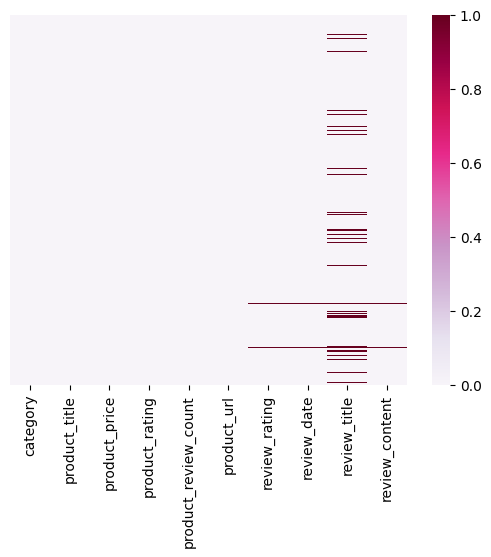

In [8]:
# Visualize the missing data
sns.heatmap(DF.isnull(), cmap='PuRd', yticklabels=False)
plt.show()

From the heatmap, we can see that most columns like category, product_title, and product_price 
are complete with no missing values. 
However, some columns such as review_rating, review_date, review_title, and review_content 
have a few missing entries.

In [9]:
#check the sum of the missing values
DF.isnull().sum()


category                 0
product_title            0
product_price            0
product_rating           0
product_review_count     0
product_url              0
review_rating            6
review_date              6
review_title            88
review_content           6
dtype: int64

In [10]:
#Drop the null value in the reviews column
DF.dropna(subset=['review_content'], inplace=True)

In [11]:
#check again
DF.isnull().sum()

category                 0
product_title            0
product_price            0
product_rating           0
product_review_count     0
product_url              0
review_rating            0
review_date              0
review_title            82
review_content           0
dtype: int64

After removing rows with missing review_content, only the review_title column still has 82 missing values. Since review_content holds the main text for analysis, we decided to keep these rows and fill the missing titles with 'No Title' to maintain data consistency without losing valuable information.


In [12]:
# Fill missing titles with a placeholder 
DF['review_title'].fillna('No Title', inplace=True)


In [13]:
#check again
DF.isnull().sum()

category                0
product_title           0
product_price           0
product_rating          0
product_review_count    0
product_url             0
review_rating           0
review_date             0
review_title            0
review_content          0
dtype: int64

now we have no missing values

In [14]:
# Count the number of duplicated rows in the DataFrame
DF.duplicated().sum()

np.int64(0)

That means there are no duplicate rows in our DataFrame

### Correct Data Types

In this section, we will transform columns to their correct types for further analysis

In [15]:

# Convert dates
DF['review_date'] = pd.to_datetime(DF['review_date'], errors='coerce')


# Remove commas and trailing dots, then convert to float
DF['product_price'] = DF['product_price'].astype(str)  
DF['product_price'] = DF['product_price'].str.replace(',', '')  
DF['product_price'] = DF['product_price'].str.replace(r'\.$', '', regex=True)  
DF['product_price'] = DF['product_price'].astype(float)  


DF['product_rating'] = DF['product_rating'].astype(float)
DF['review_rating'] = DF['review_rating'].astype(float)

DF['product_review_count'] = DF['product_review_count'].astype(str)
DF['product_review_count'] = DF['product_review_count'].str.replace(',', '')
DF['product_review_count'] = DF['product_review_count'].str.replace(r'\.$', '', regex=True)
DF['product_review_count'] = DF['product_review_count'].astype(float)

In [16]:
DF.head()

category                                      product_title  \
0  Smart Locks and Entry  TP-Link Tapo Smart Door Lock, Deadbolt | Keyle...   
1  Smart Locks and Entry  TP-Link Tapo Smart Door Lock, Deadbolt | Keyle...   
2  Smart Locks and Entry  TP-Link Tapo Smart Door Lock, Deadbolt | Keyle...   
3  Smart Locks and Entry  TP-Link Tapo Smart Door Lock, Deadbolt | Keyle...   
4  Smart Locks and Entry  TP-Link Tapo Smart Door Lock, Deadbolt | Keyle...   

   product_price  product_rating  product_review_count  \
0          114.0             4.5                 357.0   
1          114.0             4.5                 357.0   
2          114.0             4.5                 357.0   
3          114.0             4.5                 357.0   
4          114.0             4.5                 357.0   

                           product_url  review_rating review_date  \
0  https://us.amazon.com/dp/B0DKQQ6Z7Q            5.0  2025-06-15   
1  https://us.amazon.com/dp/B0DKQQ6Z7Q            5.0  2025-06-05   
2  https://us.amazon.com/dp/B0DKQQ6Z7Q            5.0  2025-10-07   
3  https://us.amazon.com/dp/B0DKQQ6Z7Q            4.0  2025-03-27   
4  https://us.amazon.com/dp/B0DKQQ6Z7Q            5.0  2025-09-10   

                                        review_title  \
0  5.0 out of 5 starsBest Smart Lock Ever ‚Äì A Tot...   
1  5.0 out of 5 starsExcellent smart lock! Highly...   
2  5.0 out of 5 starsFingerprint Recognition is A...   
3  4.0 out of 5 starsGood option, especially if y...   
4          5.0 out of 5 starsExcellent and a bargain   

                                      review_content  
0  This smart lock is hands-down my best purchase...  
1  LOVE this lock! Super easy installation and pr...  
2  This lock is great. I've had it installed on m...  
3  This was a good choice for me, especially sinc...  
4  I installed a wyze door lock gave up on me aft...

### Exploratory Data Analysis (EDA)

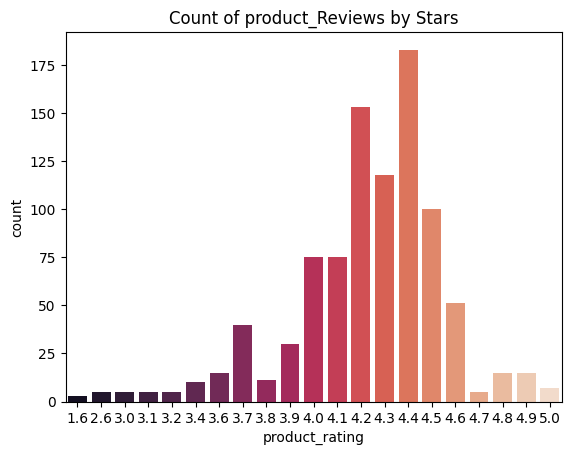

In [17]:
# Plot the count plot for the ratings
sns.countplot(x = DF['product_rating'],palette="rocket")
plt.title('Count of product_Reviews by Stars')

plt.show()

Here we can see that we have the ratings have decimals like 4.5, 4.3, etc., which creates too many unique categories on the x-axis. 

To make it easier to read, we're keeping only the whole number part (like 4, 5).

In [18]:
DF['rating_int'] = DF['product_rating'].astype(int) 
DF['rating_int'] = DF['product_rating'].round().astype(int) 

round() is used to round the decimal ratings (e.g., 4.8 to 5, 4.3 to 4) to the nearest integer, improving readability by reducing unique categories, then astype(int) ensures the result is an integer type

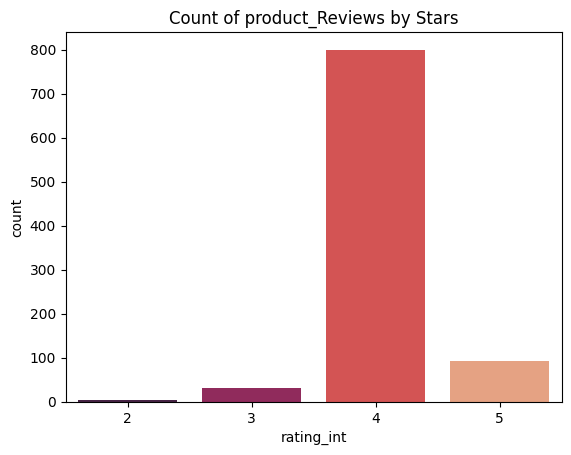

In [19]:
# Plot the count plot for the ratings
sns.countplot(x = DF['rating_int'],palette="rocket")
plt.title('Count of product_Reviews by Stars')

plt.show()

Here, we observe that the product_rating column contains 4 unique rating categories. Most customers seem to be satisfied with their purchases. The majority of reviews are 4 stars (around 750). In comparison, there are fewer reviews with 2 stars (less than 50), 3 stars (about 50), and 5 stars (around 100). This suggests that the products are generally well-received, with most users rating them positively.

<Axes: xlabel='product_price', ylabel='Count'>

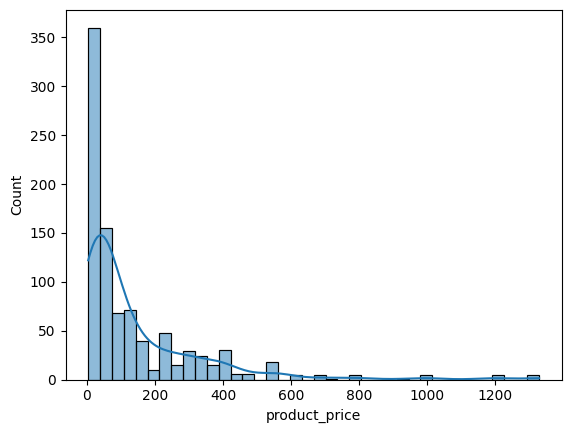

In [20]:
#Price Distribution
sns.histplot(DF['product_price'], kde=True)

We can clearly see that most products are priced below $200. After that, the numbers drop quickly, with only a few higher-priced items. This shows that most products are affordable.

### Relationships Between Variables

<Axes: xlabel='product_price', ylabel='product_rating'>

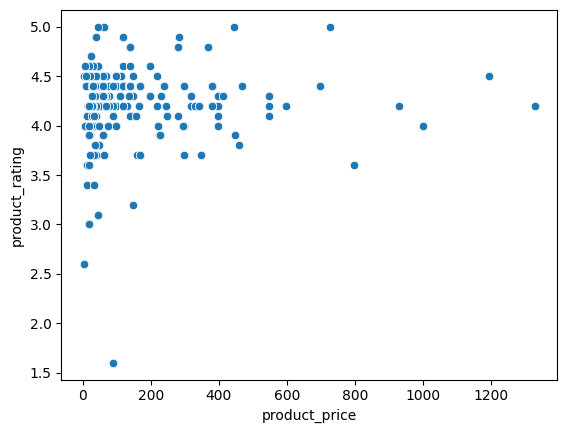

In [21]:
#Price vs Rating
sns.scatterplot(data=DF, x='product_price', y='product_rating')


The "Price vs Rating" chart shows that most products are priced between $0 and $600 and usually get decent ratings between 3.5 and 4.5. More expensive products are less common and have more mixed ratings. Interestingly, very few cheap products have ratings below 3.0, which suggests that even lower-priced items are generally satisfying. Overall, products in the mid-price range seem to get the best reviews.

<Axes: xlabel='rating_int', ylabel='review_rating'>

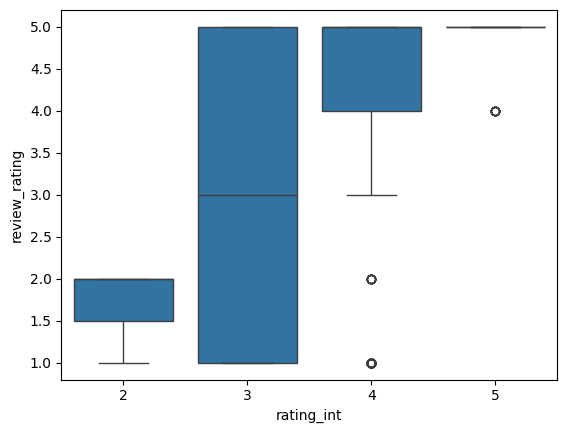

In [22]:
#Review Rating vs Product Rating
sns.boxplot(data=DF, x='rating_int', y='review_rating')

The boxplot shows how individual review ratings relate to the overall product rating (from 2 to 5 stars). Products with lower ratings mostly get low reviews, while higher-rated products tend to get better reviews. For 5-star products, most reviews are close to perfect, though a few low ratings show that not everyone is fully satisfied. Overall, higher product ratings match up with better individual reviews, but there are some exceptions.

<Axes: xlabel='review_date'>

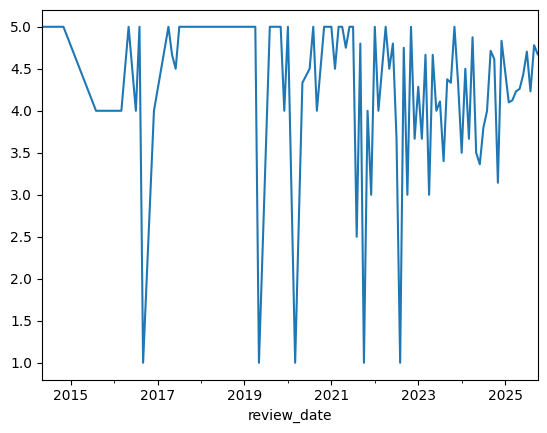

In [23]:
#Time-based Analysis
DF['review_date'] = pd.to_datetime(DF['review_date'])
DF.groupby(DF['review_date'].dt.to_period('M'))['review_rating'].mean().plot()


We can observe from that chart that ratings dropped around 2017, peaked in 2021, and became less stable after that, averaging around 4.0. In recent years, there‚Äôs also been a big rise in the number of reviews, showing more customer activity

In [24]:
CSV_FILE_PATH = "../data/processed-data.csv"
DF.to_csv(CSV_FILE_PATH, index=False, encoding='utf-8')
print(f" Data saved to: {CSV_FILE_PATH}")

 Data saved to: ../data/processed-data.csv


### Text-Based EDA (Reviews) for machine learning 

In this step, we prepare a subset of the original Amazon product review dataset
specifically for sentiment analysis tasks. Since the goal of sentiment analysis is to evaluate customer opinions based on textual data, we only need two key variables:

- review_content ‚Äì the textual review provided by the customer
- review_rating  ‚Äì the numerical rating (typically on a 1‚Äì5 scale)

In [26]:
reviews_df = DF[['review_content', 'review_rating']].copy()
reviews_df

review_content  review_rating
0    This smart lock is hands-down my best purchase...            5.0
1    LOVE this lock! Super easy installation and pr...            5.0
2    This lock is great. I've had it installed on m...            5.0
3    This was a good choice for me, especially sinc...            4.0
4    I installed a wyze door lock gave up on me aft...            5.0
..                                                 ...            ...
927  The media could not be loaded.This cutting-edg...            5.0
928  Marvelous product. WiFi throughout house is mu...            5.0
929  This is the best router I ever seen. It is by ...            5.0
930  I bought it because it was a good option for m...            1.0
931  Seemed to be working fine currently , haven't ...            4.0

[926 rows x 2 columns]

In [27]:
reviews_df['review_rating'] = reviews_df['review_rating'].astype(int)
print(reviews_df['review_rating'].unique())

[5 4 1 3 2]


we see that review_rating contains five unique values: 1, 2, 3, 4, and 5

In [28]:
# Drop rows from the DataFrame where the 'review_rating' column is equal to 3
reviews_df.drop(reviews_df[reviews_df['review_rating'] == 3].index, inplace=True)

In [29]:
def encoder(review_rating):
    if review_rating in {1, 2}: # negative
        return 0 
    if review_rating in {4, 5}: # positive
        return 1

**The encoder()** function is used to convert review ratings into binary sentiment labels:

- Ratings of 1 or 2 are considered negative and are encoded as 0.

- Ratings of 4 or 5 are considered positive and are encoded as 1.

This helps simplify the task for a machine learning model by focusing only on clear positive or negative sentiments, while neutral ratings (like 3) are typically excluded from training to avoid ambiguity

In [30]:
# transform star_rating into the sentiment
reviews_df['review_rating'] = reviews_df['review_rating'].apply(lambda review_rating: 
    encoder(review_rating=review_rating))

In [31]:
reviews_df

review_content  review_rating
0    This smart lock is hands-down my best purchase...              1
1    LOVE this lock! Super easy installation and pr...              1
2    This lock is great. I've had it installed on m...              1
3    This was a good choice for me, especially sinc...              1
4    I installed a wyze door lock gave up on me aft...              1
..                                                 ...            ...
927  The media could not be loaded.This cutting-edg...              1
928  Marvelous product. WiFi throughout house is mu...              1
929  This is the best router I ever seen. It is by ...              1
930  I bought it because it was a good option for m...              0
931  Seemed to be working fine currently , haven't ...              1

[909 rows x 2 columns]

In [32]:
sentiment_counts = reviews_df['review_rating'].value_counts()
print("Sentiment counts:")
print(sentiment_counts)

Sentiment counts:
review_rating
1    821
0     88
Name: count, dtype: int64


This indicates that our dataset is imbalanced, with a significantly higher number of positive reviews compared to negative ones. To address this issue, we will apply oversampling to the minority class by duplicating or synthetically generating additional negative samples, ensuring a more balanced distribution of sentiment labels

In [33]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = reviews_df[reviews_df['review_rating'] == 1]
df_minority = reviews_df[reviews_df['review_rating'] == 0]

# Upsample minority class
df_minority_upsampled = resample(df_minority,replace=True,n_samples=len(df_majority), random_state=42)

# Combine majority and upsampled minority
balanced_df = pd.concat([df_majority, df_minority_upsampled])


In [34]:
sentiment_counts = balanced_df['review_rating'].value_counts()
print("Sentiment counts:")
print(sentiment_counts)

Sentiment counts:
review_rating
1    821
0    821
Name: count, dtype: int64


Now, both classes have the same number of samples (821 each), which helps create a more balanced dataset for training the model

In [35]:
balanced_df.shape

(1642, 2)

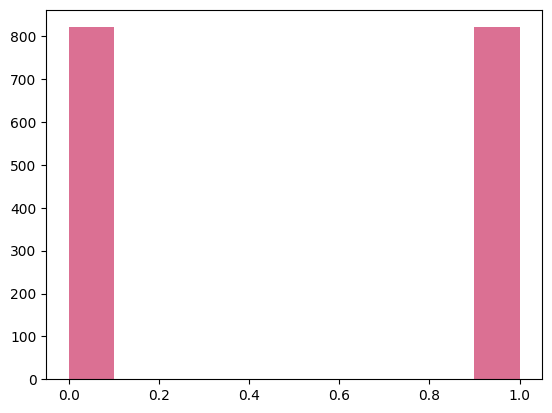

In [36]:
#classes proportion
plt.hist(balanced_df['review_rating'],color='palevioletred')
plt.show()

In [37]:
# Let's get the length of the verified_reviews column
balanced_df['review_length'] = balanced_df['review_content'].apply(len)

In [38]:
balanced_df.columns

Index(['review_content', 'review_rating', 'review_length'], dtype='object')

the review_length column added successfully

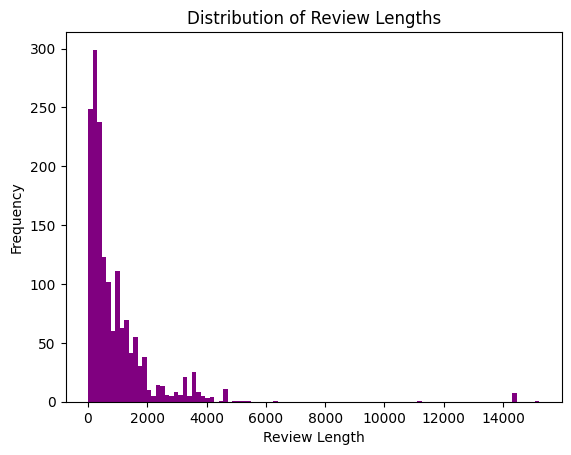

In [39]:
# Plot the histogram for the length
balanced_df['review_length'].plot(bins = 100, kind = 'hist',color='Purple')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')

plt.show()

What we notice is that a lot of reviews are actually quite short, maybe in the range of zero to around 1000 characters. This essentially indicates that most customers prefer to leave relatively concise feedback.

At the same time, there are some people who really love the product and decide to write a long, detailed review. Similarly, some other customers might be frustrated or upset, so they leave a really long review as well. These longer reviews are much less common, but they do exist.

In [40]:
# Let's get the max and min length of the verified_reviews column
print(f"the maximum review is : {balanced_df['review_length'].max()}")
print(f"the minimum review is : {balanced_df['review_length'].min()}")

the maximum review is : 15215
the minimum review is : 10


the maximum is 9764. So there is a customers who maybe love the product so much and he wrote Almost 9764 characters. 

In [41]:
# Let's see the longest message by taking its index first
max_length_index = balanced_df['review_length'].idxmax()
print(max_length_index)

862


In [42]:
balanced_df['review_content'][862]

'*** 1 Year Review Update ***I decided to keep the system. After a few firmware updates and once TP-Link fixed the AP only mode such that the main and guest networks are truly separated I switched over from using it as a router to an AP solution. It has worked flawlessly since and without any performance degradation\'s.I still do not like the app-centric approach for "management" (cannot call it that honestly); insight would probably be more appropriate. But, I will be moving in the future to an enterprise grade solution (this solution purchase has just been a stop-gap until that time and I finalize my network architecture). For the average home consumer that is not very tech-savvy (which is the audience this product really targets) it is overall very simple to get up and running with very few issues, especially at this price point.I have submitted over a dozen feature requests to TP-Link and almost all of them have been discarded by the manufacturer (but at least acknowledged); of the

# PLOT THE WORDCLOUD


represent the frequency or the importance of each word.

In [43]:
# Obtain only the positive reviews
positive = balanced_df[balanced_df['review_rating'] == 1]

In [44]:
positive

review_content  review_rating  \
0    This smart lock is hands-down my best purchase...              1   
1    LOVE this lock! Super easy installation and pr...              1   
2    This lock is great. I've had it installed on m...              1   
3    This was a good choice for me, especially sinc...              1   
4    I installed a wyze door lock gave up on me aft...              1   
..                                                 ...            ...   
926      ŸÖŸÜÿ™ÿ¨ ÿπŸÖŸÑŸä ŸàÿßÿµŸÑŸä Ÿàÿ≥ÿ±Ÿäÿπ Ÿàÿ≥ŸáŸÑ ÿßŸÑÿßÿ≥ÿ™ÿÆÿØÿßŸÖRead more              1   
927  The media could not be loaded.This cutting-edg...              1   
928  Marvelous product. WiFi throughout house is mu...              1   
929  This is the best router I ever seen. It is by ...              1   
931  Seemed to be working fine currently , haven't ...              1   

     review_length  
0             1353  
1             1510  
2             1863  
3              815  
4              515  
..             ...  
926             45  
927           1344  
928            163  
929           2418  
931            218  

[821 rows x 3 columns]

In [45]:
# Obtain the negative reviews only
negative = balanced_df[balanced_df['review_rating'] == 0]

In [46]:
negative

review_content  review_rating  \
493  Update - okay so this update comes an hr later...              0   
79   You can‚Äôt assign different access levels. Eith...              0   
792  This device kept breaking down and the company...              0   
597  I bought this speaker to use with my home's wi...              0   
235  These are JUNK! I cannot get it to connect, di...              0   
..                                                 ...            ...   
22   I don‚Äôt understand why no one can build a smar...              0   
49   I bought this lock because it is sold on the C...              0   
493  Update - okay so this update comes an hr later...              0   
834  What's to like? A month of frustration.I bough...              0   
431  Bought 2 of these and the remotes do not work....              0   

     review_length  
493           1141  
79             121  
792            163  
597           1975  
235            101  
..             ...  
22            1488  
49             161  
493           1141  
834           3517  
431            219  

[821 rows x 3 columns]

In [47]:
# Convert the positive sentences to list format
positive_sentences = positive['review_content'].tolist()
len(positive_sentences)

821

In [48]:
# Join all positive reviews into one large string
postive_sentences_as_one_string = ' '.join(positive_sentences)

In [49]:
postive_sentences_as_one_string

'This smart lock is hands-down my best purchase of 2025 so far, and it‚Äôs made such a difference in my daily life! I was fed up with my Nest x Yale lock, which gave me constant problems‚Äîconnectivity issues, finicky unlocking, you name it. This lock is a complete game-changer, and I‚Äôm already planning to buy more for my back door and upstairs patio.The installation was a breeze, taking me less than 20 minutes with just a screwdriver. It‚Äôs so intuitive to set up, even for someone who‚Äôs not super tech-savvy. The lock offers so many ways to use it‚Äîkeypad, app, fingerprint, or even a physical key for backup‚Äîwhich makes it incredibly versatile for my family‚Äôs needs. It locks with ease every time, giving me peace of mind knowing my home is secure.The app is a standout: clean, user-friendly, and reliable. I can lock or unlock my door from anywhere, check access history, or share temporary codes with guests without any hassle. It‚Äôs everything I wanted the Nest x Yale to be but 

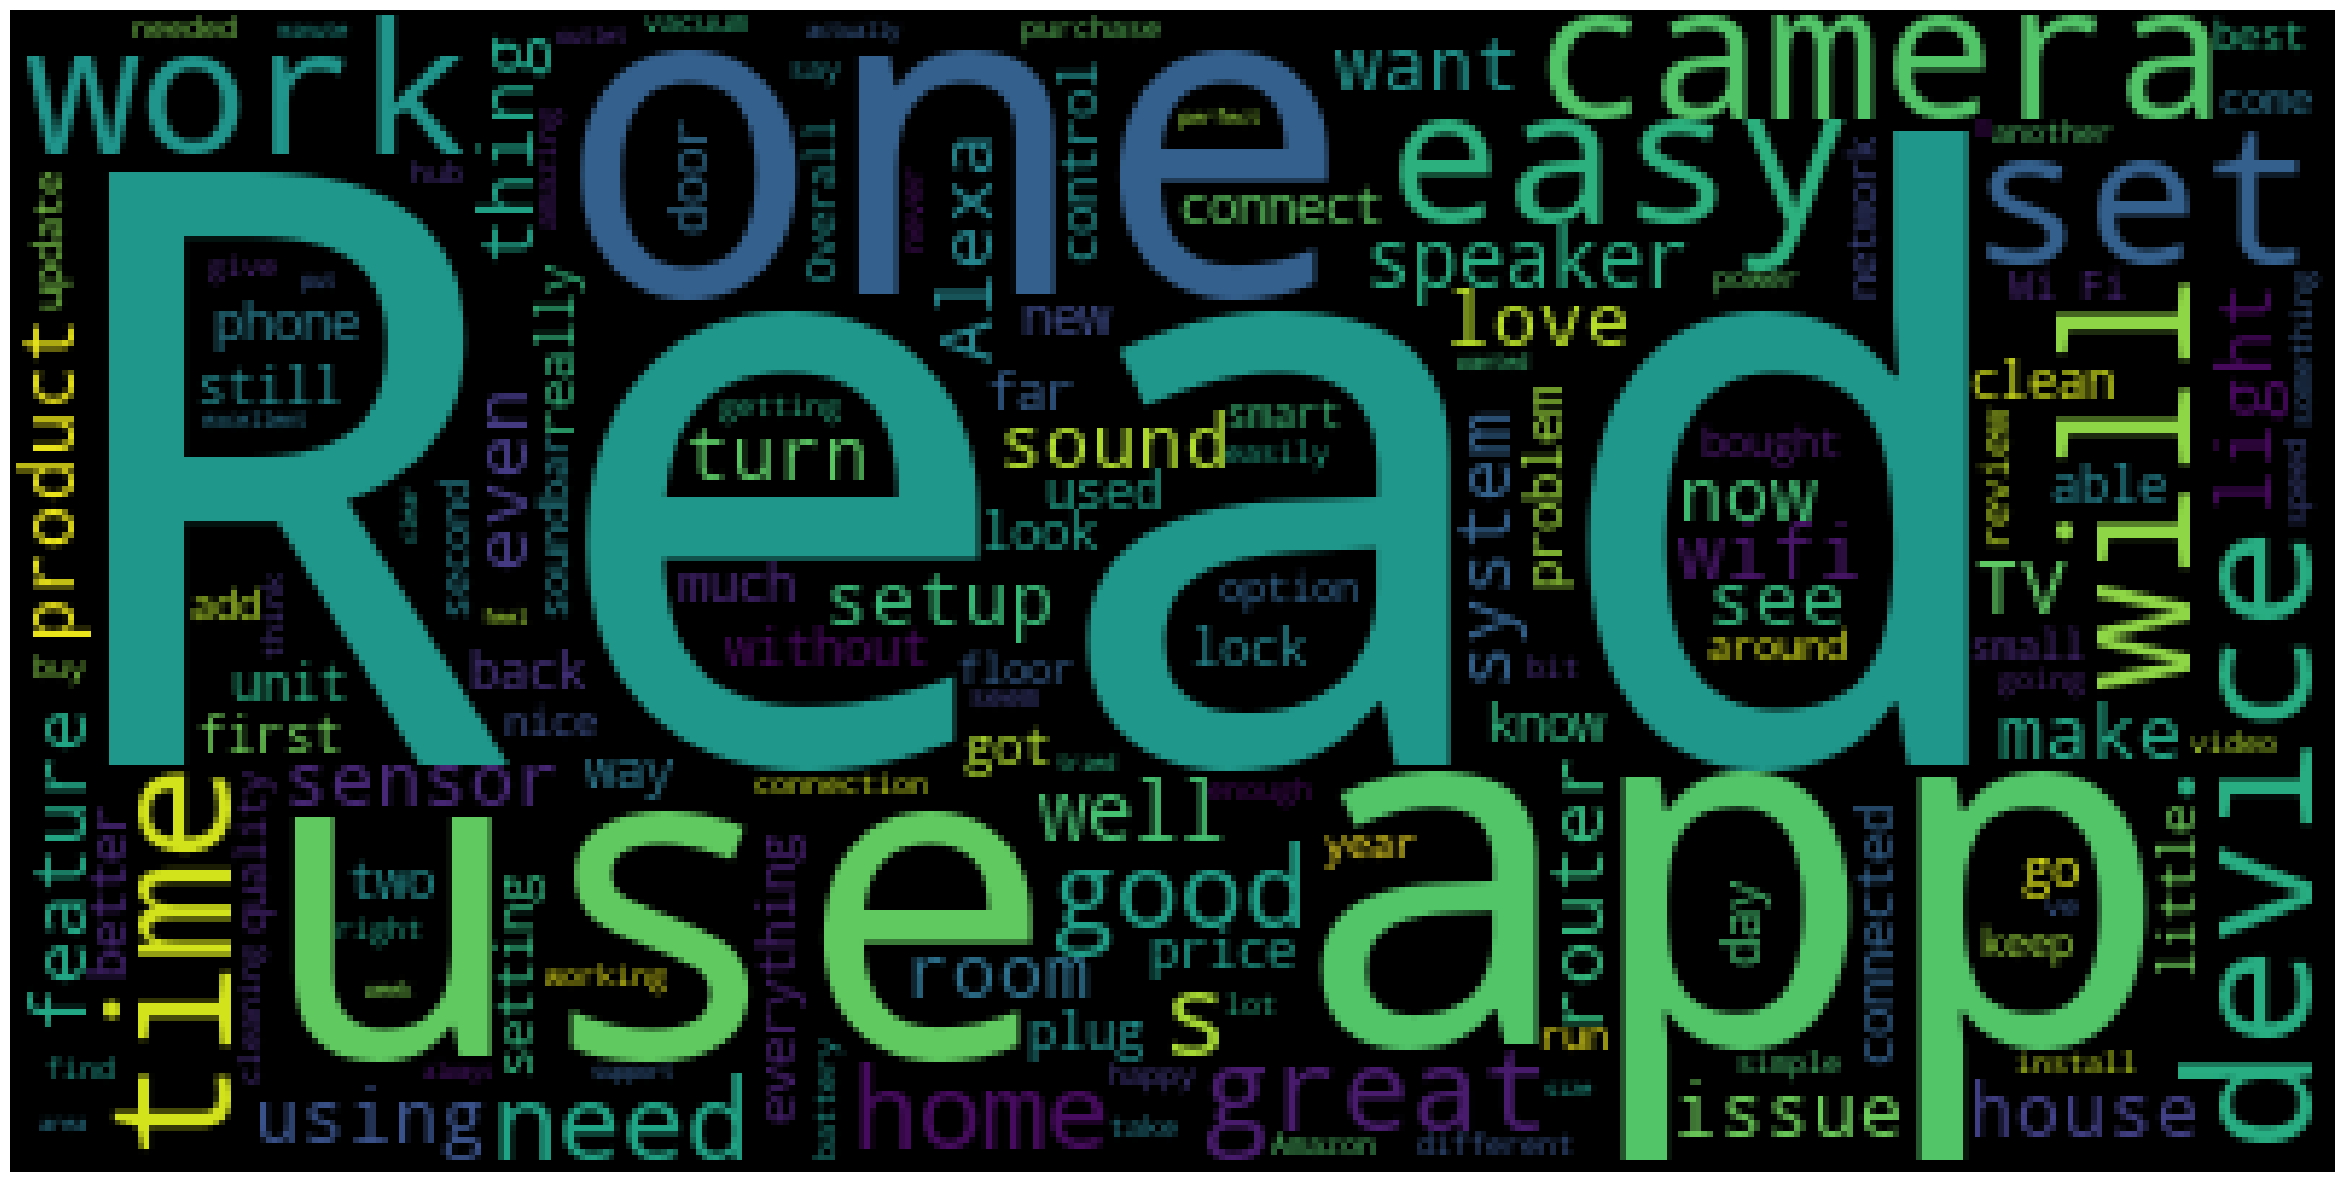

In [50]:
#plot the wordCLoud
plt.figure(figsize=(30,30))
plt.imshow(WordCloud().generate(postive_sentences_as_one_string))
plt.axis('off')
plt.show()

In [51]:
# Convert the negative sentences to list format
negative_sentences = negative['review_content'].tolist()
len(negative_sentences)

821

In [52]:
# Join all negative reviews into one large string
negative_sentences_as_one_string = ' '.join(negative_sentences)

In [53]:
negative_sentences_as_one_string

'Update - okay so this update comes an hr later. This is absolute garbage. The settings make no sense and there is no explanation on what they even do. It‚Äôs already deleted recordings that are suppose to save to the sd card and is keeps on disconnection when the router is only a few feet away. My other cameras that were half the price work better and the settings actually make sense and they explain things! Don‚Äôt even bother with this.I will post an update in the next couple days but honestly this seems like it‚Äôs getting returned. Nothing makes sense for how this is set up and it‚Äôs constantly disconnecting from my WiFi and the router is 5 feet away in the same room and there is no wall in between. Not sure about it being able to record anything at all because of the connection problems. I need it to watch my dogs. The alarm setting makes no sense at all. I contacted support so let‚Äôs see if I can get some answers. So far this thing doesn‚Äôt seem to be worth the money. The onl

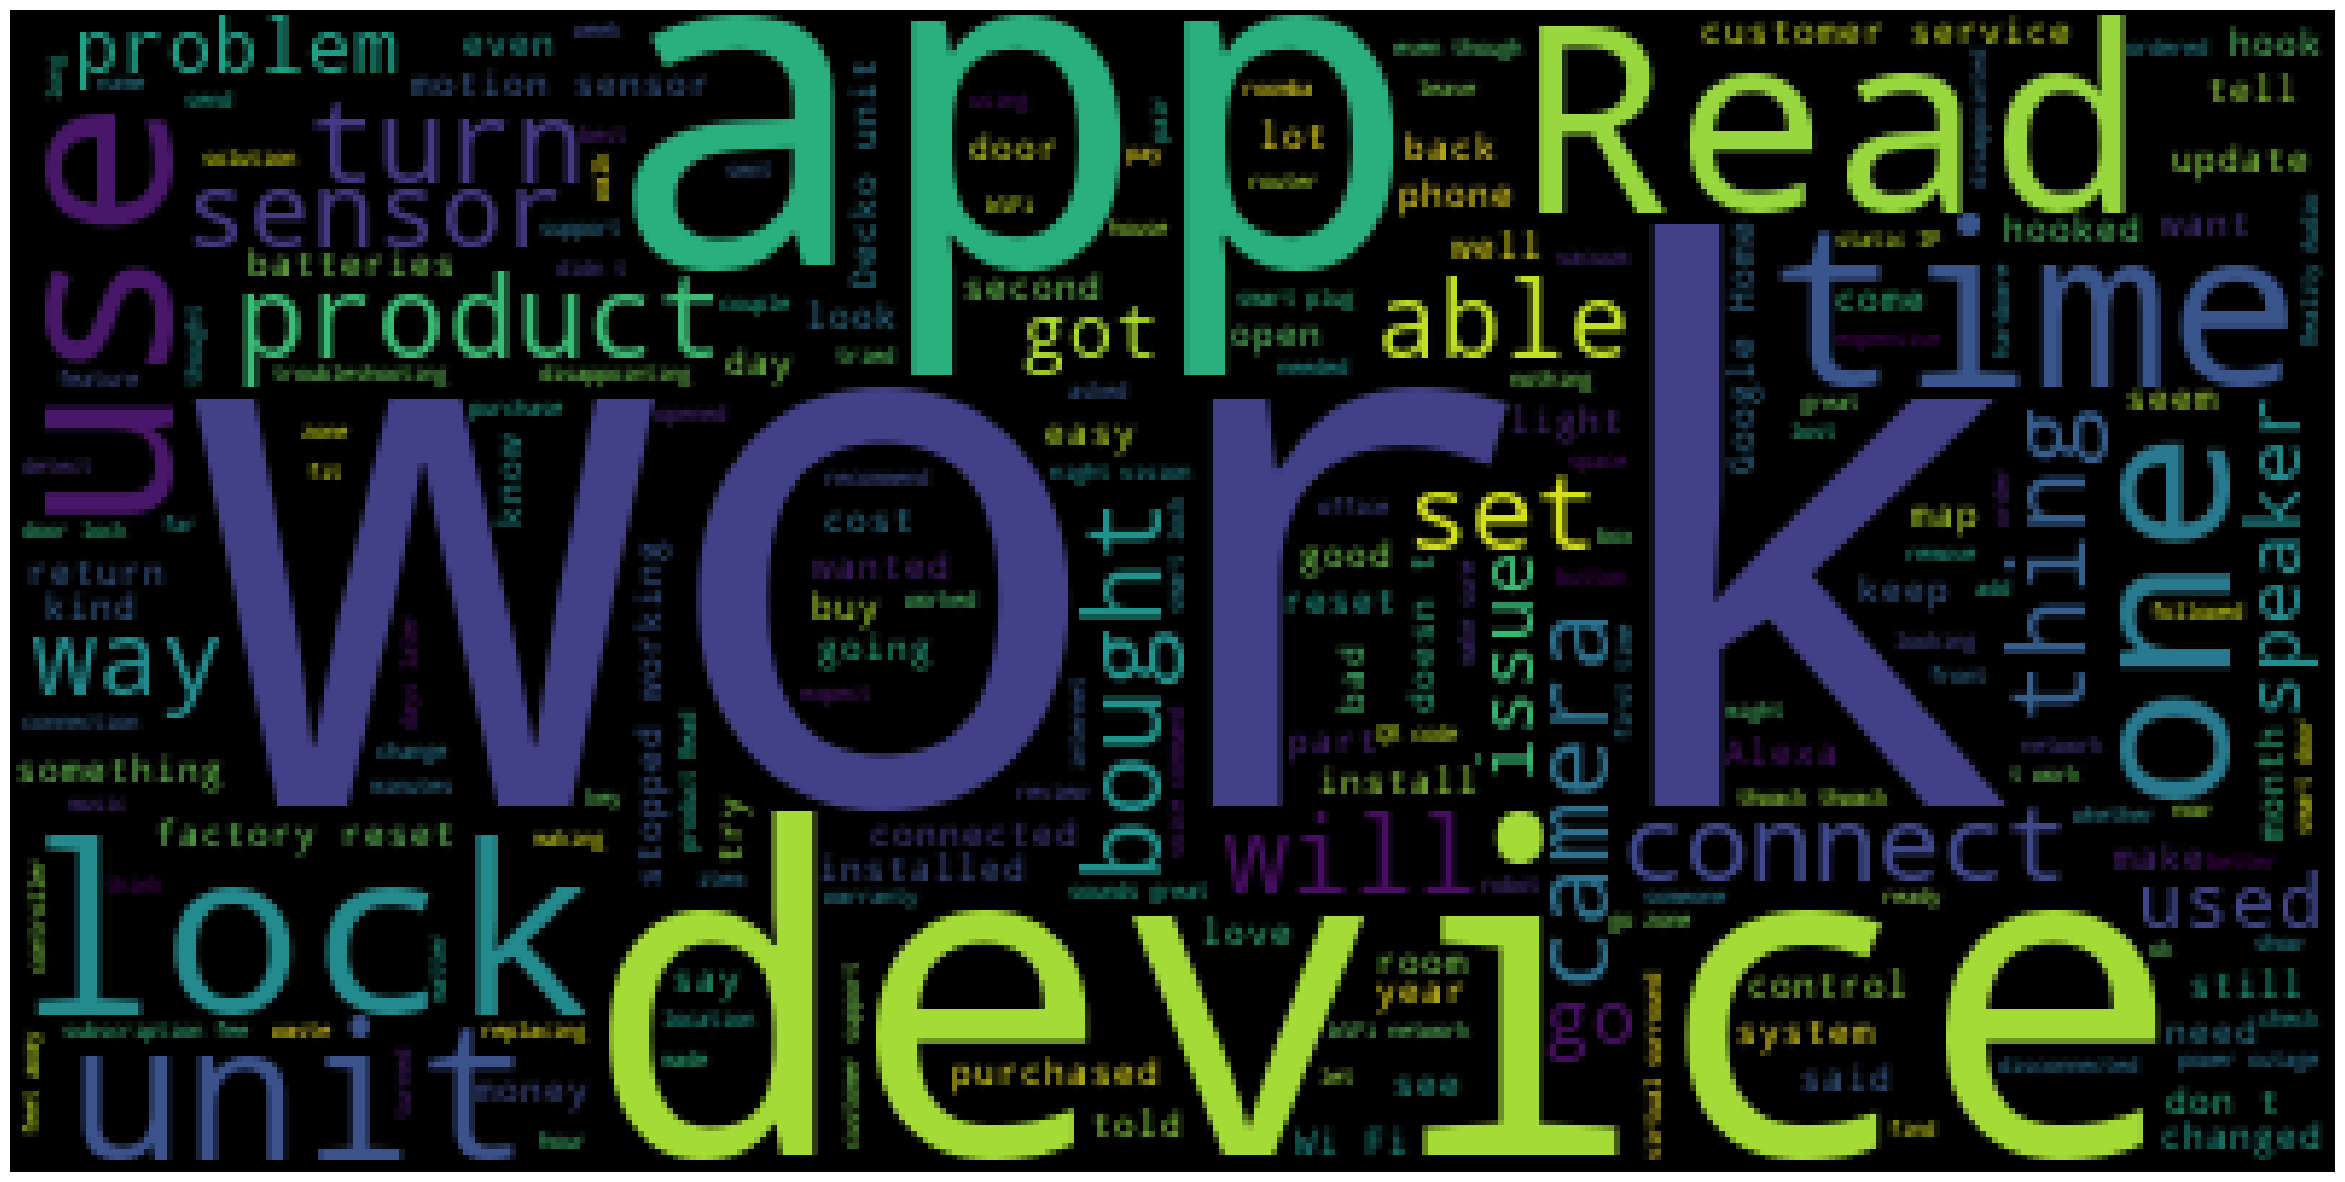

In [54]:
#plot the wordCLoud
plt.figure(figsize=(30,30))
plt.imshow(WordCloud().generate(negative_sentences_as_one_string))
plt.axis('off')
plt.show()

### TEXT DATA CLEANING 

Before we will feed our machine learning model the reviews we have to clean up the data first. 

In [55]:
ExampleTest = '$I DO NOT Love Data Engineering &And Making PROJECTS!...!!!'

In [56]:
#remove all the different punctuations in the english language.
Example_without_punc = re.sub('[^a-zA-Z]', ' ',ExampleTest)
Example_without_punc_space = re.sub(' +', ' ', Example_without_punc)

Example_without_punc_space

' I DO NOT Love Data Engineering And Making PROJECTS '

In [57]:
#make all the letter in lower case
Example_without_punc_lowe=Example_without_punc.lower()
Example_without_punc_lowe

' i do not love data engineering  and making projects       '

The next thing we want to do is to remove what we call **stopwords**. These are common words that don't add much value when we train a machine learning model such as for example, I, you, we, all these are genetic common words, we call stopwords. It's a common practice to remove these stopwords in machine learning projects.

In [58]:
Stopwords=set(stopwords.words('english'))
Example_without_punc_lowe_clean = [word for word in Example_without_punc_lowe.split() if word not in Stopwords ]
Example_without_punc_lowe_clean

['love', 'data', 'engineering', 'making', 'projects']

We can see all the common words that don't add much value are removed succefully , but we have a problem , our goal is to do sentiment analysis of product , and in this case we have to respect the negotion bsc I not love data engineer its not like i love data engineer !

In [59]:
Stopwords_modified=set(stopwords.words('english')) - {'no', 'not','will', 'nor', 'but', 'however', 'although', 'yet', 'unfortunately', 'never', 'none', 'nobody', 'nowhere', 'nothing', 'neither', 'no one', 'without'}
clean_text = [word for word in Example_without_punc_lowe.split() if word not in Stopwords_modified ]
clean_text

['not', 'love', 'data', 'engineering', 'making', 'projects']

In [60]:
#Text Normalization
#generate root form of derived (inflected) words.
lemmatizer = WordNetLemmatizer()
lemma=lemmatizer.lemmatize(' '.join(clean_text))
lemma

'not love data engineering making projects'

###  CREATE A PIPELINE TO REMOVE PUNCTUATIONS, STOPWORDS and lemmatization 

In [61]:
def preprocess_reviews(text):
    cleaned_text = re.sub('[^a-zA-Z]', ' ', text)
    cleaned_text = re.sub(' +', ' ', cleaned_text)
    cleaned_text = cleaned_text.lower()
    tokenized_text = cleaned_text.split()  # Tokenization
    lemma_text = [lemmatizer.lemmatize(word) for word in tokenized_text if word not in Stopwords_modified]
    lemma_text_str = ' '.join(lemma_text)
    return lemma_text_str

# corpus=[]
# for i in range (0,df.shape[0]):
#     cleaned_text = re.sub('[^a-zA-Z]', ' ', df.iloc[i]['Reviews'])
#     cleaned_text=re.sub(' +', ' ',cleaned_text)
#     cleaned_text = cleaned_text.lower()
#     tokenized_text = cleaned_text.split() #Tokenization
#     lemma_text=[lemmatizer.lemmatize(word) for word in tokenized_text  if word not in Stopwords_modified ]
#     lemma_text_str = ' '.join(lemma_text)
#     corpus.append(lemma_text_str)

In [62]:
balanced_df['review_content']

0      This smart lock is hands-down my best purchase...
1      LOVE this lock! Super easy installation and pr...
2      This lock is great. I've had it installed on m...
3      This was a good choice for me, especially sinc...
4      I installed a wyze door lock gave up on me aft...
                             ...                        
22     I don‚Äôt understand why no one can build a smar...
49     I bought this lock because it is sold on the C...
493    Update - okay so this update comes an hr later...
834    What's to like? A month of frustration.I bough...
431    Bought 2 of these and the remotes do not work....
Name: review_content, Length: 1642, dtype: object

In [63]:
balanced_df['review_content'] = balanced_df['review_content'].apply(preprocess_reviews)

In [64]:
balanced_df['review_content']

0      smart lock hand best purchase far made differe...
1      love lock super easy installation programming ...
2      lock great installed back door home six month ...
3      good choice especially since several tapo prod...
4      installed wyze door lock gave year jamming con...
                             ...                        
22     understand no one build smart lock actually wo...
49     bought lock sold canadian amazon site unfortun...
493    update okay update come hr later absolute garb...
834    like month frustration bought skydrop system w...
431    bought remote not work would not pair hub chan...
Name: review_content, Length: 1642, dtype: object

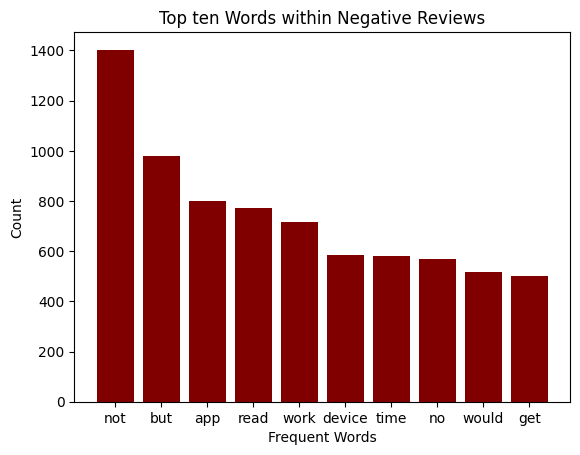

In [65]:
negative_reviews = balanced_df[balanced_df['review_rating'] == 0]['review_content']

corpus_negative = [preprocess_reviews(review) for review in negative_reviews]
all_negative_reviews = ' '.join(corpus_negative)
words = all_negative_reviews.split()
word_counts = Counter(words)
top_words = word_counts.most_common(10)
words, counts = zip(*top_words)
plt.bar(words, counts,color ='maroon')
plt.xlabel('Frequent Words')
plt.ylabel('Count')
plt.title('Top ten Words within Negative Reviews')
plt.show()


The bar chart of negative reviews shows that words like ‚Äúnot,‚Äù ‚Äúbut,‚Äù and ‚Äúapp‚Äù appear most often. This suggests that many low-rated reviews focus on problems or frustrations, such as apps not working, issues with devices, difficulties reading content, or wasted time

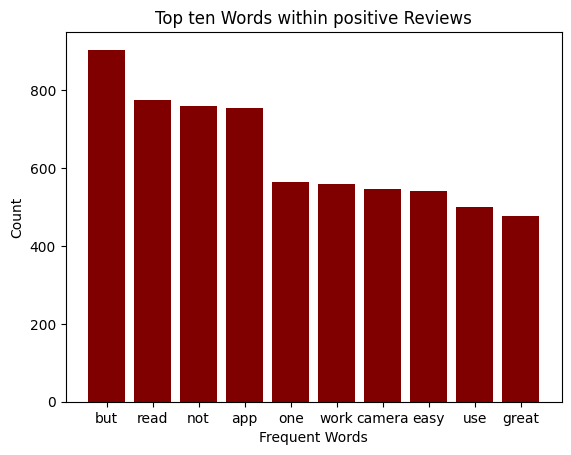

In [66]:
positive_reviews = balanced_df[balanced_df['review_rating'] == 1]['review_content']

corpus_positive = [preprocess_reviews(review) for review in positive_reviews]
all_positive_reviews = ' '.join(corpus_positive)
words = all_positive_reviews.split()
word_counts = Counter(words)
top_words = word_counts.most_common(10)
words, counts = zip(*top_words)
plt.bar(words, counts,color ='maroon')
plt.xlabel('Frequent Words')
plt.ylabel('Count')
plt.title('Top ten Words within positive Reviews')
plt.show()


The bar chart of positive reviews shows common words like ‚Äúbut,‚Äù ‚Äúread,‚Äù ‚Äúapp,‚Äù and ‚Äúcamera.‚Äù Most feedback praises the app‚Äôs features, ease of use, and quality, though words like ‚Äúbut‚Äù and ‚Äúnot‚Äù hint that some reviewers still mention minor issues.

In [67]:
X_train,X_test,Y_train, Y_test = train_test_split(balanced_df['review_content'], balanced_df['review_rating'], test_size=0.25, random_state=30)


with longer documents, we typically see higher average count values on words that carry very little meaning, this will overshadow shorter documents that have lower average counts with same frequencies, as a result, we will use TfidfTransformer to reduce this redundancy:

Term Frequencies (Tf) divides number of occurrences for each word by total number of words
Term Frequencies times Inverse Document Frequency (Tfidf) downscales the weights of each word (assigns less value to unimportant stop words ie. "the", "are", etc)

In [68]:
tf_idf= TfidfVectorizer(ngram_range=(1,3))
tf_x_train = tf_idf.fit_transform(X_train)
tf_x_test = tf_idf.transform(X_test)


In [88]:
# Save the trained model to a file
joblib.dump(tf_idf, './models/tfidfvectorizer_reviews.joblib')

['./models/tfidfvectorizer_reviews.joblib']

**Note** :
after every model i will run a Grid Search of the best parameters on a grid of possible values, instead of tweaking the parameters of various components of the chain.
Then i will fit the grid search to our training data set
Finally i will test the accuracy of our final classifier and chose the best model 

# Logistic regression

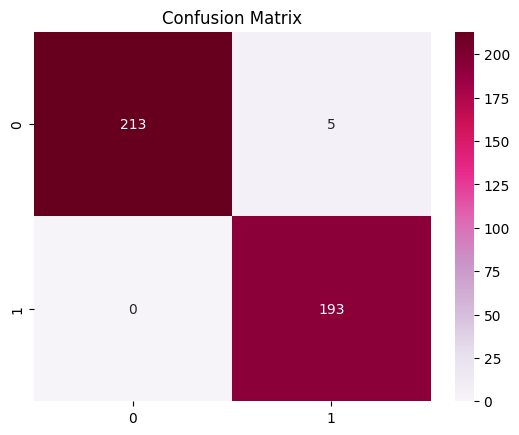

 the evaluation metrics of this model : 
[[213   5]
 [  0 193]]

Accuracy Score: 0.9878345498783455
Precision Score : 1.0
Recall Score : 0.9747474747474747
F1 Score : 0.9872122762148338
------------------------------------------------------------ 
                      Classification Report                  
------------------------------------------------------------ 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       213
           1       1.00      0.97      0.99       198

    accuracy                           0.99       411
   macro avg       0.99      0.99      0.99       411
weighted avg       0.99      0.99      0.99       411



In [70]:

Model = LogisticRegression()
Model.fit(tf_x_train, Y_train)
y_pred = Model.predict(tf_x_test)

cm = confusion_matrix(y_pred, Y_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='PuRd')
plt.title('Confusion Matrix')
plt.show()


print(' the evaluation metrics of this model : ')
print(cm)
print("\nAccuracy Score:", accuracy_score(Y_test, y_pred))
print('Precision Score : ' + str(precision_score(Y_test,y_pred)))
print('Recall Score : ' + str(recall_score(Y_test,y_pred)))
print('F1 Score : ' + str(f1_score(Y_test,y_pred)))


print('------------------------------------------------------------ ')
print('                      Classification Report                  ')
print('------------------------------------------------------------ ')
print(classification_report(Y_test, y_pred))

Below is the summary of the classification report:

**Precision** determines how many objects selected were correct.

**Recall** determines  how many objects that should have been selected were actually selected.

**F1 score** measures the weights of recall and precision.

**Support** is the number of occurrences of each class.


98.78% accuracy level in predicting the sentiment analysis and the overall result here explains that the products in this dataset are generally positively rated.



In [71]:
# calculate the accuracy score of the model to see if I Have overfitten
y_pred_train = Model.predict(tf_x_train)
y_pred_test = Model.predict(tf_x_test)

accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred_test)
print("Accuracy on Training Set:", accuracy_train)
print("Accuracy on Testing Set:", accuracy_test)

Accuracy on Training Set: 0.9991876523151909
Accuracy on Testing Set: 0.9878345498783455


### Model tuning

In [72]:
model_tuning = LogisticRegression()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [50,100, 500]
}

GS = GridSearchCV(estimator=model_tuning, param_grid=param_grid, cv=3, verbose=True, n_jobs=-1, scoring='accuracy')

GS.fit(tf_x_train, Y_train)

print("Best Parameters:", GS.best_params_)

best_logistic_regression = GS.best_estimator_
y_pred_best = best_logistic_regression.predict(tf_x_test)

print("Accuracy Score:", accuracy_score(Y_test, y_pred_best))
print('Precision Score:', precision_score(Y_test, y_pred_best))
print('Recall Score:', recall_score(Y_test, y_pred_best))
print('F1 Score:', f1_score(Y_test, y_pred_best))


Fitting 3 folds for each of 225 candidates, totalling 675 fits
Best Parameters: {'C': 10, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy Score: 0.9878345498783455
Precision Score: 1.0
Recall Score: 0.9747474747474747
F1 Score: 0.9872122762148338


after running the grid search, the logistic regression Classifier has improved to 91.38% accuracy level 

### rebuild logistic regression with the best parametres 

In [73]:
bestLogR = LogisticRegression(C=10,penalty='l2',max_iter=50,solver='newton-cg')
bestLogR.fit(tf_x_train, Y_train)
Y_pred = bestLogR.predict(tf_x_test)

acc_LogR=accuracy_score(Y_test, Y_pred)
print("\nAccuracy Score:",acc_LogR )



Accuracy Score: 0.9878345498783455


In [74]:
new_review = 'Works great so far! Easy to install, fingerprint sensor is fast, and the app is simple to use. Very happy with this purchase'
tfidf=tf_idf.transform([new_review])
bestLogR.predict(tfidf)

array([1])

In [75]:

new_review = 'bad product'
tfidf=tf_idf.transform([new_review])
bestLogR.predict(tfidf)

array([0])

# Naive bayes

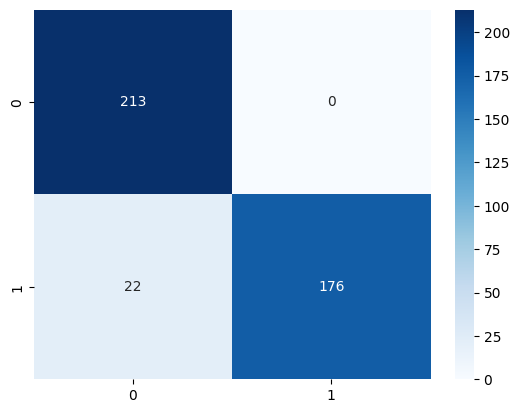

The evaluation metrics of this model:

Accuracy Score: 0.9464720194647201
Precision Score: 1.0
Recall Score: 0.8888888888888888
F1 Score: 0.9411764705882353
------------------------------------------------------------ 
                      Classification Report                  
------------------------------------------------------------ 
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       213
           1       1.00      0.89      0.94       198

    accuracy                           0.95       411
   macro avg       0.95      0.94      0.95       411
weighted avg       0.95      0.95      0.95       411



In [76]:
NB_classifier = MultinomialNB()
NB_classifier.fit(tf_x_train, Y_train)

Y_predict_testCL = NB_classifier.predict(tf_x_test)

cm = confusion_matrix(Y_test, Y_predict_testCL)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

print('The evaluation metrics of this model:')
print("\nAccuracy Score:", accuracy_score(Y_test, Y_predict_testCL))
print('Precision Score:', precision_score(Y_test, Y_predict_testCL))
print('Recall Score:', recall_score(Y_test, Y_predict_testCL))
print('F1 Score:', f1_score(Y_test, Y_predict_testCL))

print('------------------------------------------------------------ ')
print('                      Classification Report                  ')
print('------------------------------------------------------------ ')
print(classification_report(Y_test,Y_predict_testCL))


In [77]:
y_pred_trainCL = NB_classifier.predict(tf_x_train)
accuracy_train = accuracy_score(Y_train, y_pred_trainCL)
accuracy_test = accuracy_score(Y_test, Y_predict_testCL)

# Print the accuracies
print("Accuracy on Training Set:", accuracy_train)
print("Accuracy on Testing Set:", accuracy_test)

Accuracy on Training Set: 0.9967506092607636
Accuracy on Testing Set: 0.9464720194647201


## Model tuning

In [78]:
nb_model = MultinomialNB()

param_grid = {
    'alpha': [0.1, 0.5, 1.0],
    'fit_prior': [True, False]
}

grid_search_cl = GridSearchCV(estimator=nb_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)
grid_search_cl.fit(tf_x_train, Y_train)

print("Best Parameters:", grid_search_cl.best_params_)

best_nb = grid_search_cl.best_estimator_
y_pred_best = best_nb.predict(tf_x_test)
print("Accuracy Score:", accuracy_score(Y_test, y_pred_best))
print('Precision Score:', precision_score(Y_test, y_pred_best))
print('Recall Score:', recall_score(Y_test, y_pred_best))
print('F1 Score:', f1_score(Y_test, y_pred_best))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'alpha': 0.1, 'fit_prior': True}
Accuracy Score: 0.975669099756691
Precision Score: 1.0
Recall Score: 0.9494949494949495
F1 Score: 0.9740932642487047


### rebuild the model with the best parametres

In [79]:
bestNB = MultinomialNB(alpha=0.1,fit_prior=True)
bestNB.fit(tf_x_train, Y_train)
Y_pred = bestNB.predict(tf_x_test)

acc_NB=accuracy_score(Y_test, Y_pred)
print("\nAccuracy Score:",acc_NB )


Accuracy Score: 0.975669099756691


# Comparison of accuracy


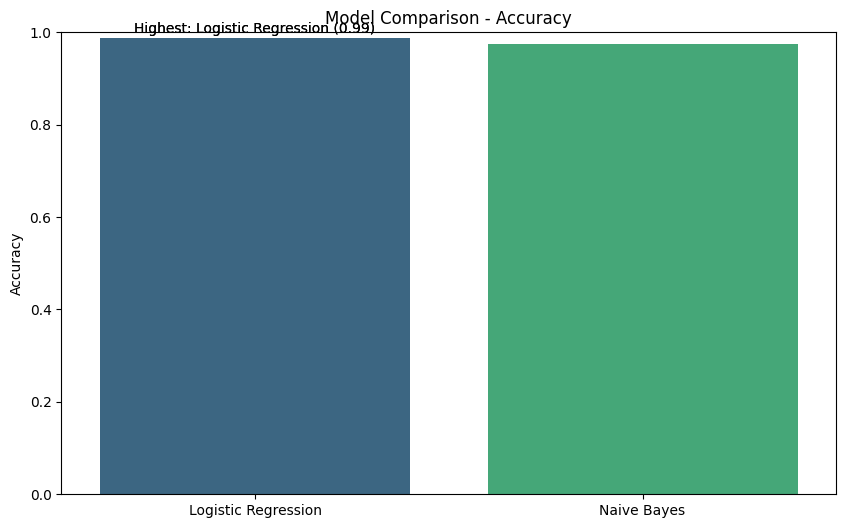

The model with the highest accuracy is Logistic Regression with an accuracy of 0.99


In [82]:
model_names = ['Logistic Regression', 'Naive Bayes']
accuracy_values = [acc_LogR, acc_NB]

best_model_index = accuracy_values.index(max(accuracy_values))
best_model_name = model_names[best_model_index]
best_accuracy = accuracy_values[best_model_index]

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracy_values, palette='viridis')
plt.text(best_model_index, best_accuracy + 0.01, f'Highest: {best_model_name} ({best_accuracy:.2f})', ha='center')

# Annotate the plot with the highest accuracy
plt.text(best_model_index, best_accuracy + 0.01, f'Highest: {best_model_name} ({best_accuracy:.2f})', ha='center')

plt.title('Model Comparison - Accuracy')
plt.ylim(0, 1) 
plt.ylabel('Accuracy')
plt.show()

print(f"The model with the highest accuracy is {best_model_name} with an accuracy of {best_accuracy:.2f}")


# choosing Logistic Regression as the best model

In [89]:
# Save the trained model to a file
joblib.dump(bestLogR, './models/Logistic_regression_reviews.joblib')

['./models/Logistic_regression_reviews.joblib']

In [91]:
loaded_model = joblib.load(open('./models/Logistic_regression_reviews.joblib','rb'))
loaded_tfidvectorizer = joblib.load('./models/tfidfvectorizer_reviews.joblib')